### code from [Gradual_unfreeze_example.ipynb](https://colab.research.google.com/github/Kelvinthedrugger/-AI-/blob/main/emo_nbs/CODE_EXAMPLE_TO_PUSH/EMO_AI_context_model/Gradual_unfreeze_example.ipynb)
### Setup model

### Import

In [ ]:
%%capture
!pip install transformers tokenizers
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
#import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__


In [ ]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_variable_size(size=10):
    from sys import getsizeof
    """# can be 'locals()' or 'globals()'"""
    for name, size in sorted(((name, getsizeof(value)) for name, value in list(
                              globals().items())), key= lambda x: -x[1])[:size]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


### Tokenizer setup

In [ ]:
!mkdir -p tokenizer
## load pretrained tokenizer information
def setup_tokenizer():
  tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
  tokenizer.save_pretrained("tokenizer")

setup_tokenizer()
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])

        return (sequences_padded, attention_masks_padded), labels
## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]



### Model define

### 如果要用[V1, A1, V2, A2]的話，要改模型架構（從output數量開始改）

In [ ]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)


### 試試看新模型 (date: 6/24)

In [ ]:
class NewEmoModel(nn.Module):
    def __init__(self, base_model, n_classes=2, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

        self.last_classifier = nn.Sequential(
            nn.Dropout(dropout),
            # n_classes: [V,A] -> 2
            # 4: v_bar, v_std, a_bar, a_std
            nn.Linear(2*n_classes+4, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )


    def forward_roberta(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        # maybe do some pooling / RNNs... go crazy here!
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

    def forward(self, input_):
        #X, atten_mask, V_bar, V_std, A_bar, A_stat = input_
        # in1, in2 has X, atten_mask, respectively
        in1, in2, V_bar, V_std, A_bar, A_stat = input_
        VAsj = self.forward_roberta( in1 )
        VAj_1 = self.forward_roberta( in2 )
        # split VAs into VA from sj...sk and sj+1
        #VAsj, VAj_1 = VAs[0], VAs[1]
        # calculate new avg and std of V, A here
        #V_new, A_new = 0, 0
        return self.last_classifier(torch.concat([VAsj, VAj_1, V_bar, V_std, A_bar, A_stat]))


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

In [ ]:
n_classes = 2
model = NewEmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, n_classes)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1362: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


### load pretrained model
#### note that i mount my own drive for convenience
#### to load pretrained weight, on can use gdown to load the weights

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1EwKCylRdQMPZlFIjFV0r0QiTO5Sgy0Sz?usp=sharing

#### don't have to run the import drive ones if you are not going
#### to save files for example in your drive

In [ ]:
"mount drive first"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/EMO_AI_ver_2/model_weights

0627_1_epoch_all_unfreezed.pt
0627_1_epoch_classifier_unfreezed.pt
0627_epoch_1_seed_1337.pt
0629_on_pseudo_1_epoch_all_unfreezed.pt
0629_on_pseudo_1_epoch_classifier_unfreezed.pt
0629_on_pseudo_epoch_1_seed_1337.pt


In [ ]:
latest_weight_name = "0627_1_epoch_all_unfreezed.pt"
# copy to /content
!cp /content/drive/MyDrive/EMO_AI_ver_2/model_weights/{latest_weight_name} /content
!ls *.pt

0627_1_epoch_all_unfreezed.pt


#### load pretrained weight to model

In [ ]:
latest_weight_name

In [ ]:
"load the weight to model"
model.load_state_dict( torch.load(latest_weight_name)() )

<All keys matched successfully>

### 平均值: 簡單, 用 Avg_new = Avg_old * (1 - ratio) + Data_new * ratio就好
### 標準差: 我決定先用變異數(計算較簡單,aka,不用開根號): 追蹤sigma X^2，變異數 = Avg(Sigma X^2) - Avg**2

### 'stats'應該不用梯度?，要注意一下

In [ ]:
"we're doing regression!"
criterion = nn.MSELoss()
# optimizer
lr = 1e-4
optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
"it all worked!"
n_classes = 2
model = NewEmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, n_classes)

# forward pass
# [sent1, sent2, V_avg, V_平方和, A_avg, A_平方和]
arr = ["句子1", "句子2", 0.16, 0, 0.5, 0]

# initialize stats
ln = 0 # the passed number of data
stats = torch.tensor( [ arr[2:] ] ) # expected shape: (1,4) (or, (batch, 4))
enc = tokenizer.encode_plus(arr[0])
a = (torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))

enc = tokenizer.encode_plus(arr[1])
b = (torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))

out1 = model.forward_roberta(a) # Sk...j
out2 = model.forward_roberta(b) # Sj+1

ln += out1.shape[0] # the batch_size
ratio = out1.shape[0] / ln

in_f = torch.concat([out1, out2, stats[:,0:1], stats[:,1:2]**2/ln - stats[:,0:1], stats[:,2:3], stats[:,3:]**2/ln - stats[:,2:3]], dim=1)

output = model.last_classifier(in_f) # shape: (1,2) (or, (bs, 2))

# update average & standard deviation (sigma(x**2) actually)
stats[:,0] = stats[:,0] * (1-ratio) + output[:,0] * ratio
stats[:,2] = stats[:,2] * (1-ratio) + output[:,1] * ratio
stats[:,1] = stats[:,1]* (1-ratio) + output[:,0] ** 2 * ratio
stats[:,3] = stats[:,3]* (1-ratio) + output[:,1] ** 2 * ratio
# loss & update model weight
loss = criterion(output, torch.tensor([[0.5, -0.5]])) # the label is made up
loss.backward()
optimizer.step()

optimizer.zero_grad()

## 先用手邊的資料train!!
## 處理資料
### 變數清單

one: 原始抓到的text跟emoji。

emoji_map: emoji的名字 對 emoji。

text_emoji_data: text對emoji

rev_emoji_map: emoji 對 emoji的名字。

Data: 最後的(text, VA)。如果text裡面有emoji，說明當初抓的時候，那個emoji要嘛

1. 在74個emoji list裡面，但是一直搜尋不到。
2.emoji不在74個裡面

### load files

In [ ]:
# "可以點這個連結來看data長怎樣"
# "這個是emoji 對 [V,A]"
# !wget -q https://www.dropbox.com/s/e9bxb4qx19be6nn/face_with_va.csv
# import pandas as pd
# face_va = pd.read_csv("face_with_va.csv")
# face_va.head()
# import pickle
# def read_pkl(fname):
#   with open(fname, "rb") as f:
#     ret = pickle.load(f)
#     f.close()
#   return ret
# "key -> [V,A]"
# FVA = {k:[v,a] for k, v, a in zip(face_va['face'], face_va['V_norm'], face_va['A_norm'])}
# "check FVA, passed"
# for k, v in FVA.items():
#   assert isinstance(k, str)
#   assert isinstance(v[0], float)
#   assert isinstance(v[1], float)

,face,V,A,V_norm,A_norm
0,angryface,2.97,6.80,0.379310,0.855346
1,poutingface,2.09,7.53,0.266922,0.947170
2,facewithsymbolsonmouth,2.39,7.48,0.305236,0.940881
3,tiredface,3.01,6.70,0.384419,0.842767
4,wearyface,3.02,6.31,0.385696,0.793711


#### everytime you see '/drive' stuff, just skip

In [ ]:
# 用pseudo label
!ls /content/drive/MyDrive/MiinWu

DataPreprocess.ipynb   RawData	    StealData_Selenium_Update.ipynb
FinalPseudoData.jsonl  RawData.zip  TestDataFormat_MiinWu.txt


In [ ]:
!cp /content/drive/MyDrive/MiinWu/FinalPseudoData.jsonl /content
!ls *jsonl

FinalPseudoData.jsonl


#### use this to load the pseudo labelled data
#### if you use the .pbz2 one, run decompress_pickle() on the downloaded data

In [ ]:
import bz2 # to zip a pickle object
import pickle
def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = pickle.load(data)
 return data

In [ ]:
# load pseudo label data

url = "https://raw.githubusercontent.com/Kelvinthedrugger/EmoAI2023/master/data/FinalPseudoData.jsonl"

url_zipped = "https://raw.githubusercontent.com/Kelvinthedrugger/EmoAI2023/master/data/FinalPseudoData_compressed.pbz2"

# one of url, url_zipped
github_link_to_pseudo = ...

!wget -q {github_link_to_pseudo}

In [ ]:
# load it
import json

def get_jsonl_data(fname, dirname=""):
  return list(map(json.loads, open(f"{dirname}{fname}", "r")))

pseudo_data = get_jsonl_data("FinalPseudoData.jsonl")

In [ ]:
len(pseudo_data)

42422

In [ ]:
pseudo_data[5]

{'X': ['【日劇】\n下一個檔期追劇預定～\n主演群竟然都是認識的名字\n金曜ドラマ『トリリオンゲーム』【公式】 on Twitter',
  '目黑蓮跟美櫻又共演了欸',
  0.3844189017,
  0.0,
  0.8427672956,
  0.0],
 'Y': [0.4546615581, 0.7018867925]}

#### keep going, randomize the data
#### set seed to debug easier & reproduce the experimental result

In [ ]:
# [sent1, sent2, v_mean, v_std, a_mean, a_std]

# train test split
import random
SEED = 1337
random.seed(SEED)
rdx = random.uniform # function to do randomization

In [ ]:
plurk_train, plurk_val, plurk_test = [], [], []

#for ele in DS:
#for ele in Data:
for ele in pseudo_data:
  sp = rdx(0,1)
  if sp > 0.2:
    plurk_train.append(ele)
  elif sp > 0.1:
    plurk_val.append(ele)
  else:
    plurk_test.append(ele)

In [ ]:
len(plurk_train), len(plurk_val), len(plurk_test)

(33918, 4218, 4286)

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.base_model.device

device(type='cpu')

In [ ]:
model.to(device)

NewEmoModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
model.base_model.device

device(type='cuda', index=0)

### Gradual unfreeze (the new version, the code way below is for reference only)

In [ ]:
"freeze the base model & classifier, leave the last_classifier only for now"
#"freeze all"
for layer in list(model.parameters()):
  layer.requires_grad = False

# unfreeze the last_classifier
for layer in list(model.last_classifier.parameters()):
  layer.requires_grad = True

In [ ]:
from tqdm import tqdm

### 大概跑30分鐘
### might take long, we haven't thought about how to do it with batch yet....
### one easy way will be to do 'optimizer.step()' at desired batch size (aka, number of passed data)

### 只用到差不多4GB的GPU RAM，想辦法增加使用率會trained的更快
### 當然，也有可能只是因為我們只train last_classifier，所以才這麼省

In [ ]:
torch.cuda.empty_cache()

In [ ]:
"we're doing regression!"
criterion = nn.MSELoss()
# optimizer
lr = 1e-4
optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
max_length = 512

In [ ]:
batch_size = 256

In [ ]:
train_loss, val_loss = [], []

#### 流程:

先餵第一句:
  * stats: data[3:]
  * concat = txt = data[0]

再第二句:
  * stats: the interated ones
  * concat: data[:2]
  * txt: data[1]

problem: 沒有第一句的[V,A]，aka, 沒有label

-> 只能先train第二句

In [ ]:
def train_it():
  model.train()

  # forward pass

  bs_count = 0 # to do batch size manually

  for i in tqdm(range(len(plurk_train))):
    data = plurk_train[i]['X']
    VA = plurk_train[i]['Y']

    # initialize stats
    ln = 0 # the passed number of data
    #stats = torch.tensor( [ [0, 0, 0, 0] ] ).cuda() # expected shape: (1,4) (or, (batch, 4))
    stats = torch.tensor([data[2:]]).cuda() # expected shape: (1,4)

    # text: list of (sent, [V,A])
    #for idx in range(len(text)):
    for idx in range(1): # the loop is not needed

      # a: all the prev sentence
      concat_text = data[0]
      enc = tokenizer.encode_plus(concat_text, max_length=max_length, truncation=True, padding=True)
      a = (torch.tensor(enc["input_ids"]).unsqueeze(0).cuda(), torch.tensor(enc["attention_mask"]).unsqueeze(0).cuda())

      # b: current sentence only
      txt = data[1]
      enc = tokenizer.encode_plus(txt, max_length=max_length, truncation=True, padding=True)
      b = (torch.tensor(enc["input_ids"]).unsqueeze(0).cuda(), torch.tensor(enc["attention_mask"]).unsqueeze(0).cuda())

      out1 = model.forward_roberta(a) # Sk...j
      out2 = model.forward_roberta(b) # Sj+1

      ln += out1.shape[0] # the batch_size
      ratio = out1.shape[0] / ln

      # calculate & pass the stats of VA into last classifier
      #in_f = torch.concat([out1, out2, stats[:,0:1], stats[:,1:2]**2/ln - stats[:,0:1], stats[:,2:3], stats[:,3:]**2/ln - stats[:,2:3]], dim=1)
      in_f = torch.concat([out1, out2, stats], dim=1)

      output = model.last_classifier(in_f) # shape: (1,2) (or, (bs, 2))

      # since we only have 1 label -> don't have to update the stats
      # update average & standard deviation (sigma(x**2) actually)
      # stats[:,0] = stats[:,0] * (1-ratio) + output[:,0] * ratio
      # stats[:,2] = stats[:,2] * (1-ratio) + output[:,1] * ratio
      # stats[:,1] = stats[:,1]* (1-ratio) + output[:,0] ** 2 * ratio
      # stats[:,3] = stats[:,3]* (1-ratio) + output[:,1] ** 2 * ratio

      # loss & update model weight
      loss = criterion(output, torch.tensor([VA]).cuda()) # the label is made up
      loss.backward()

      # count accumulated batch
      bs_count += out1.shape[0]
      if bs_count == batch_size or i == len(plurk_train)-1:
        optimizer.step()
        optimizer.zero_grad()
        bs_count = 0

      # record: don't be panic if the loss doesn't seem to vary fast
      # , which dues to the 'manual batch update' stuff
      train_loss.append(loss.item())

In [ ]:
train_it()

100%|██████████| 33918/33918 [13:17<00:00, 42.54it/s]


In [ ]:
"save the weight first"
import os
weight_path = '/content/drive/MyDrive/EMO_AI_ver_2/model_weights/'
os.path.isdir(weight_path)

True

In [ ]:
"check if it's file"
fname = "0629_on_pseudo_right_epoch_1_seed_1337.pt"
PATH = weight_path + fname
if os.path.isfile(PATH):
  print(fname, "is file, try again")
else:
  torch.save(model.state_dict(), PATH)
  print("model saved at", PATH)

model saved at /content/drive/MyDrive/EMO_AI_ver_2/model_weights/0629_on_pseudo_right_epoch_1_seed_1337.pt


In [ ]:
torch.cuda.empty_cache()

In [ ]:
"plot the train loss"
from matplotlib import pyplot as plt
def plotit(inp_L, legends=None, y_lim=0.1, figsize=(12,8), title=None):
  plt.figure(figsize=figsize)
  lgnd = []
  for inp in inp_L:
    plt.plot(range(len(inp)), inp)

  if legends is not None and isinstance(legends, list):
    plt.legend(legends)
  plt.ylim([0,y_lim])
  if title is not None:
    plt.title(title)
  plt.show()

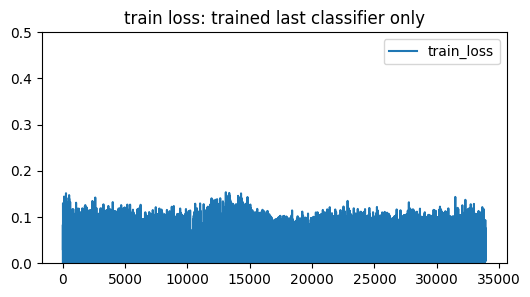

In [ ]:
#plotit([train_loss, val_loss], ["train_loss", "val_loss"], y_lim=0.5, title="freezed until -2")
plotit([train_loss], ["train_loss"], y_lim=0.5, title="train loss: trained last classifier only", figsize=(6, 3))

In [ ]:
"calculate the validation loss: just remove the gradient descent part"
def val_it():
  with torch.no_grad():
    model.eval()
    #... forward pass

    for i in tqdm(range(len(plurk_val))):
      data = plurk_val[i]['X']
      VA = plurk_val[i]['Y']

      ln = 0 # the passed number of data
      stats = torch.tensor([data[2:]]) # expected shape: (1,4)

      # text: list of (sent, [V,A])
      for idx in range(1):

        # a: concat'ed sentence
        concat_text = data[0]

        enc = tokenizer.encode_plus(concat_text, max_length=max_length, truncation=True, padding=True)
        a = (torch.tensor(enc["input_ids"]).unsqueeze(0).cuda(), torch.tensor(enc["attention_mask"]).unsqueeze(0).cuda())

        # b: current sentence only
        txt = data[1]
        enc = tokenizer.encode_plus(txt, max_length=max_length, truncation=True, padding=True)
        b = (torch.tensor(enc["input_ids"]).unsqueeze(0).cuda(), torch.tensor(enc["attention_mask"]).unsqueeze(0).cuda())

        out1 = model.forward_roberta(a) # Sk...j
        out2 = model.forward_roberta(b) # Sj+1

        ln += out1.shape[0] # the batch_size
        ratio = out1.shape[0] / ln

        # calculate & pass the stats of VA into last classifier
        #in_f = torch.concat([out1, out2, stats[:,0:1], stats[:,1:2]**2/ln - stats[:,0:1], stats[:,2:3], stats[:,3:]**2/ln - stats[:,2:3]], dim=1)
        in_f = torch.concat([out1, out2, stats.cuda()], dim=1)

        output = model.last_classifier(in_f) # shape: (1,2) (or, (bs, 2))

        # # update average & standard deviation (sigma(x**2) actually)
        # stats[:,0] = stats[:,0] * (1-ratio) + output[:,0] * ratio
        # stats[:,2] = stats[:,2] * (1-ratio) + output[:,1] * ratio
        # stats[:,1] = stats[:,1]* (1-ratio) + output[:,0] ** 2 * ratio
        # stats[:,3] = stats[:,3]* (1-ratio) + output[:,1] ** 2 * ratio

        # loss & update model weight
        loss = criterion(output, torch.tensor([VA]).cuda()) # the label is made up

        val_loss.append(loss.item())

In [ ]:
val_it()

100%|██████████| 4218/4218 [01:37<00:00, 43.28it/s]


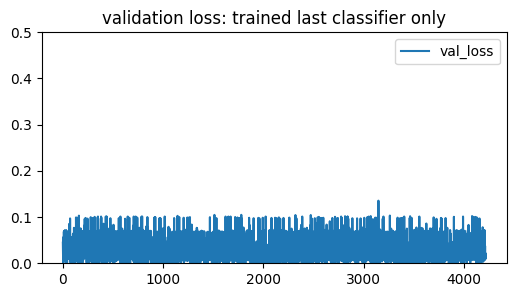

In [ ]:
plotit([val_loss], ["val_loss"], y_lim=0.5, title="validation loss: trained last classifier only", figsize=(6, 3))

### unfreeze 'model.classifier' & lower the learning rate

In [ ]:
for layer in list(model.classifier.parameters()):
  layer.requires_grad = True

In [ ]:
lr = 1e-4/2

optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### pay attention to 'stats', too

In [ ]:
train_it()

100%|██████████| 33918/33918 [12:51<00:00, 43.95it/s]


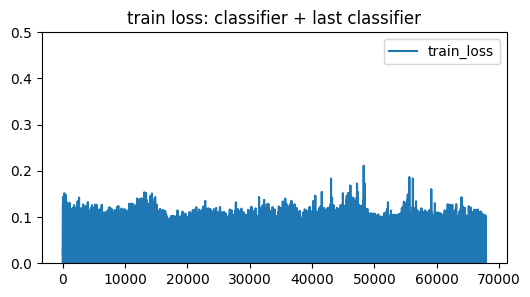

In [ ]:
plotit([train_loss], ["train_loss"], y_lim=0.5, title="train loss: classifier + last classifier", figsize=(6, 3))

In [ ]:
weight_path

'/content/drive/MyDrive/EMO_AI_ver_2/model_weights/'

In [ ]:
"save weight again"
fname_classifier = "0629_on_pseudo_right_1_epoch_classifier_unfreezed.pt"
if os.path.isfile(weight_path + fname_classifier):
  print(fname_classifier,"is file, try again")
else:
  torch.save(model.state_dict, weight_path + fname_classifier)
  print(weight_path + fname_classifier, "saved!")

/content/drive/MyDrive/EMO_AI_ver_2/model_weights/0629_on_pseudo_right_1_epoch_classifier_unfreezed.pt saved!


In [ ]:
val_it()

100%|██████████| 4218/4218 [01:24<00:00, 50.15it/s]


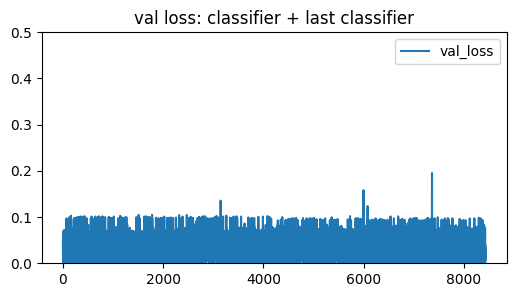

In [ ]:
plotit([val_loss], ["val_loss"], y_lim=0.5, title="val loss: classifier + last classifier", figsize=(6, 3))

### unfreeze all

In [ ]:
for layer in list(model.base_model.parameters()):
  layer.requires_grad = True

In [ ]:
"lower learning rate again"
lr = 1e-5
optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

In [ ]:
train_it()

100%|██████████| 33918/33918 [34:38<00:00, 16.32it/s]


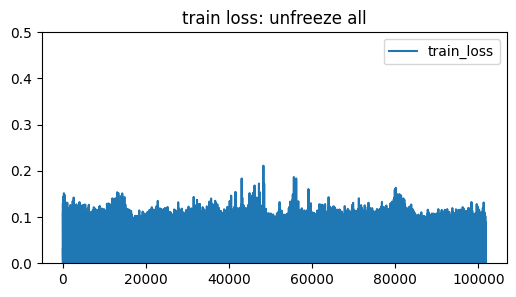

In [ ]:
# plot
plotit([train_loss], ["train_loss"], y_lim=0.5, title="train loss: unfreeze all", figsize=(6, 3))

In [ ]:
# save weight
"save weight again"
fname_final = "0629_on_pseudo_right_1_epoch_all_unfreezed.pt"
if os.path.isfile(weight_path + fname_final):
  print(fname_final,"is file, try again")
else:
  torch.save(model.state_dict, weight_path + fname_final)
  print(weight_path + fname_final, "saved!")

/content/drive/MyDrive/EMO_AI_ver_2/model_weights/0629_on_pseudo_right_1_epoch_all_unfreezed.pt saved!


In [ ]:
val_it()

100%|██████████| 4218/4218 [01:23<00:00, 50.48it/s]


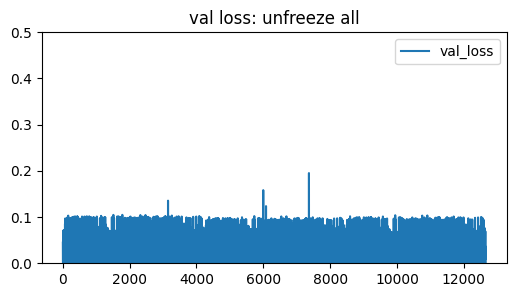

In [ ]:
# plot
plotit([val_loss], ["val_loss"], y_lim=0.5, title="val loss: unfreeze all", figsize=(6, 3))

In [ ]:
torch.cuda.empty_cache()